# Size and shape of signatures

This notebook explores sizes and shapes of individual signatures depending on their signature type.

In [1]:
import geopandas
import pandas
import dask_geopandas
import momepy
import seaborn
import pygeos
import pandas
import numpy
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt


## Measure size and shape characters

In [2]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:43365 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [3]:
pygeos.__version__

'0.9'

In [10]:
signatures = dask_geopandas.from_geopandas(geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_orig.pq"), npartitions=32)

In [11]:
signatures

,kmeans10gb,geometry,level2,signature_type
npartitions=32,,,,
0,int64,geometry,float64,object
3022,...,...,...,...
...,...,...,...,...
93682,...,...,...,...
96703,...,...,...,...


In [12]:
signatures["area"] = signatures.area
signatures["perimeter"] = signatures.length
signatures["eri"] = signatures.map_partitions(lambda p: momepy.EquivalentRectangularIndex(p).series, meta=pandas.Series(dtype="float"))
signatures["circular_compactness"] = signatures.map_partitions(lambda p: momepy.CircularCompactness(p).series, meta=pandas.Series(dtype="float"))
signatures["donut_index"] = signatures.map_partitions(lambda p: momepy.CourtyardIndex(p, momepy.CourtyardArea(p).series).series, meta=pandas.Series(dtype="float"))
signatures["fractality"] = signatures.map_partitions(lambda p: momepy.FractalDimension(p).series, meta=pandas.Series(dtype="float"))
signatures["convexity"] = signatures.map_partitions(lambda p: momepy.Convexity(p).series, meta=pandas.Series(dtype="float"))

In [13]:
%%time
signatures = signatures.compute()

CPU times: user 12.8 s, sys: 5.15 s, total: 17.9 s
Wall time: 32.1 s


In [15]:
signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_parquet("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.pq")

<ipython-input-15-9c695be00e9b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_parquet("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.pq")


In [34]:
signatures.drop(columns=["kmeans10gb", "geometry", "level2"]).to_csv("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.csv")

## Exploration of results

In [2]:
signatures = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/sizeshape.pq")

In [3]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse/Park land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Concentrated urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper concentrated urbanity",
}

signatures["signature_type"] = signatures["signature_type"].map(types)

In [4]:
signatures

,signature_type,area,perimeter,eri,circular_compactness,donut_index,fractality,convexity
0,Countryside agriculture,1.826984e+07,29577.575163,0.601828,0.439852,0.000071,1.065559,0.788857
1,Countryside agriculture,1.235908e+04,555.207264,0.892662,0.254347,0.000000,1.047118,0.983245
2,Countryside agriculture,7.234542e+05,5746.792461,0.602136,0.339522,0.000000,1.077707,0.629428
3,Countryside agriculture,1.229467e+06,6161.670240,0.731125,0.306803,0.000000,1.046892,0.799648
4,Countryside agriculture,7.604014e+06,22500.262066,0.539593,0.252670,0.000281,1.089988,0.641429
...,...,...,...,...,...,...,...,...
96699,NaN,4.070783e+04,824.963123,1.020075,0.453320,0.000000,1.004137,0.999224
96700,NaN,3.523702e+03,270.956057,0.959089,0.334764,0.000000,1.032331,0.995177
96701,NaN,1.236944e+05,1525.262336,1.017609,0.370246,0.000000,1.013789,0.965269
96702,NaN,1.526104e+03,189.735084,0.954954,0.277671,0.000000,1.052956,0.921173


In [5]:
# drop outlier clusters
signatures = signatures.dropna()

In [6]:
order = [
    "Wild countryside",
    "Countryside agriculture",
    "Urban buffer",
    "Open sprawl",
    "Disconnected suburbia",
    "Accessible suburbia",
    "Warehouse/Park land",
    "Gridded residential quarters",
    "Connected residential neighbourhoods",
    "Dense residential neighbourhoods",
    "Dense urban neighbourhoods",
    "Local urbanity",
    "Regional urbanity",
    "Metropolitan urbanity",
    "Concentrated urbanity",
    "Hyper concentrated urbanity",
]

signatures["signature_type"] = pandas.Categorical(signatures["signature_type"], categories=order, ordered=True)

<ipython-input-6-955dbae783e0>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signatures["signature_type"] = pandas.Categorical(signatures["signature_type"], categories=order, ordered=True)


In [7]:
grouped = signatures.groupby("signature_type").describe()
grouped

area                              \
                                        count          mean           std   
signature_type                                                              
Wild countryside                       6214.0  1.469363e+07  5.997410e+08   
Countryside agriculture               10882.0  8.624893e+06  7.140831e+08   
Urban buffer                          10636.0  2.969990e+06  6.339222e+07   
Open sprawl                           17357.0  2.927622e+05  3.818980e+06   
Disconnected suburbia                  9418.0  7.528544e+04  3.305071e+05   
Accessible suburbia                   10919.0  2.055632e+05  1.280101e+06   
Warehouse/Park land                   10675.0  2.306844e+05  3.414580e+06   
Gridded residential quarters           2561.0  1.020215e+05  5.970954e+05   
Connected residential neighbourhoods   5802.0  9.745088e+04  6.036783e+05   
Dense residential neighbourhoods       6815.0  1.404605e+05  1.047595e+06   
Dense urban neighbourhoods             3344.0  1.706542e+05  3.442472e+06   
Local urbanity                         1598.0  1.446739e+05  2.727705e+06   
Regional urbanity                       316.0  2.419051e+05  2.256797e+06   
Metropolitan urbanity                   135.0  1.228652e+05  1.138579e+06   
Concentrated urbanity                    11.0  7.167404e+05  2.371545e+06   
Hyper concentrated urbanity               6.0  3.823119e+05  5.858664e+05   

                                                                              \
                                              min          25%           50%   
signature_type                                                                 
Wild countryside                         0.057032  1499.198526   6508.082021   
Countryside agriculture                  0.000150   955.663816   3089.140723   
Urban buffer                             0.000879   774.805352   3084.529241   
Open sprawl                              0.000160   643.323344   1612.151800   
Disconnected suburbia                    0.001150   616.810183   1447.681618   
Accessible suburbia                      0.009560   588.376394   1507.000971   
Warehouse/Park land                      0.016327   732.048897   1865.205005   
Gridded residential quarters             0.003155   510.032001   1176.434329   
Connected residential neighbourhoods     0.485844   644.482072   1501.473957   
Dense residential neighbourhoods         0.000205   649.122630   1617.513549   
Dense urban neighbourhoods               0.099989   532.894544   1272.170461   
Local urbanity                           0.307900   501.241702   1324.764741   
Regional urbanity                        0.041376   492.984923   1230.743132   
Metropolitan urbanity                    0.269200   356.672983   1030.773091   
Concentrated urbanity                    3.496111   218.266828    349.147183   
Hyper concentrated urbanity           1797.907262  2096.072097  15499.678131   

                                                                  perimeter  \
                                                75%           max     count   
signature_type                                                                
Wild countryside                       45560.114847  3.944223e+10    6214.0   
Countryside agriculture                15668.089578  7.438020e+10   10882.0   
Urban buffer                           27159.387001  4.103858e+09   10636.0   
Open sprawl                             9317.120739  3.672014e+08   17357.0   
Disconnected suburbia                   8060.213460  9.032649e+06    9418.0   
Accessible suburbia                    18570.817476  5.079366e+07   10919.0   
Warehouse/Park land                     8534.309518  2.257328e+08   10675.0   
Gridded residential quarters            6925.344211  1.790986e+07    2561.0   
Connected residential neighbourhoods    7804.156901  1.960757e+07    5802.0   
Dense residential neighbourhoods        6993.079521  4.613231e+07    6815.0   
Dense urban neighbourhoods   

In [8]:
seaborn.set_theme(style="darkgrid")

### Area

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

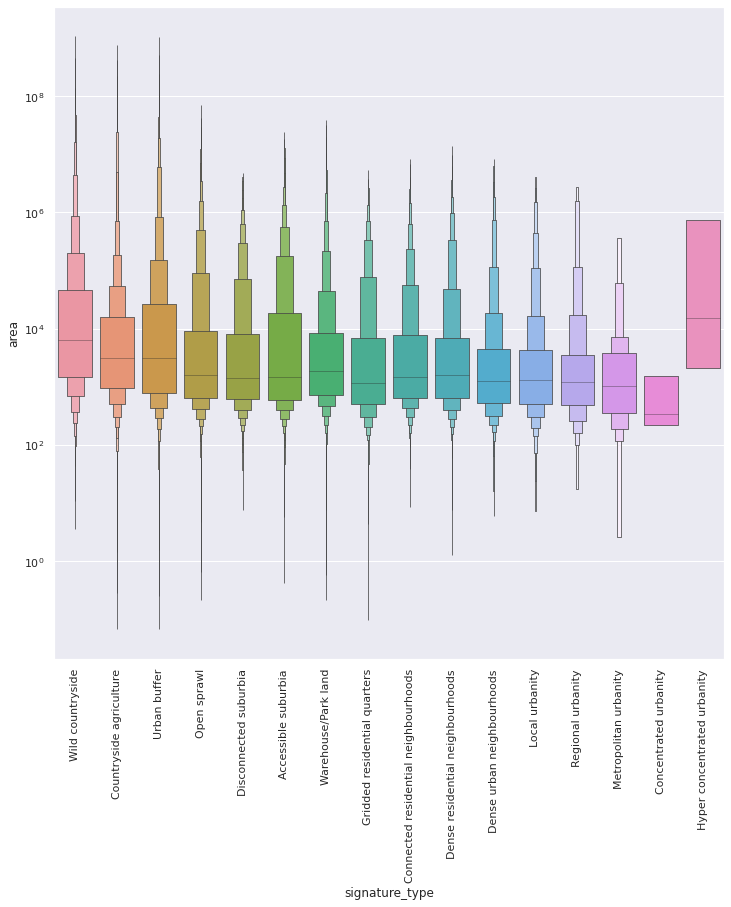

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='area', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")
ax.legend_.remove()
plt.xticks(rotation=90)

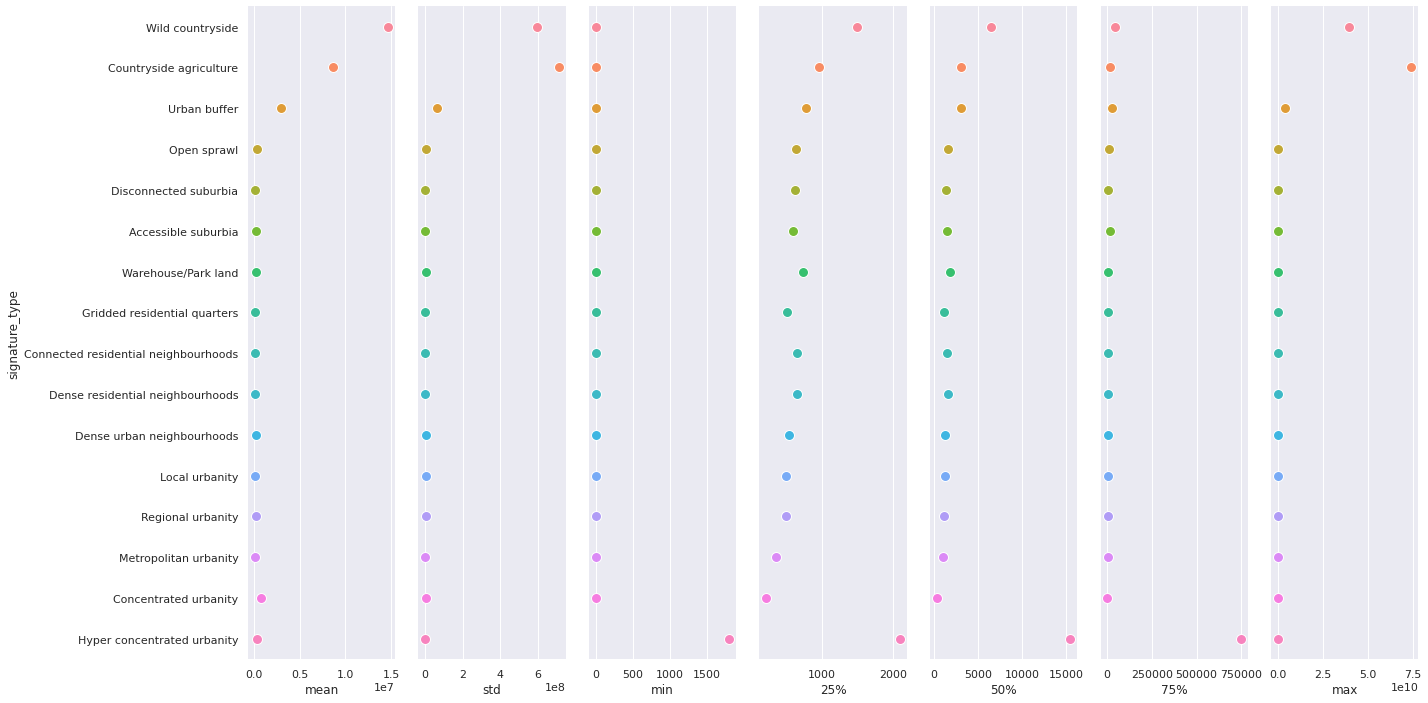

In [37]:
g = seaborn.PairGrid(grouped["area"].reset_index(),
                 x_vars=grouped["area"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

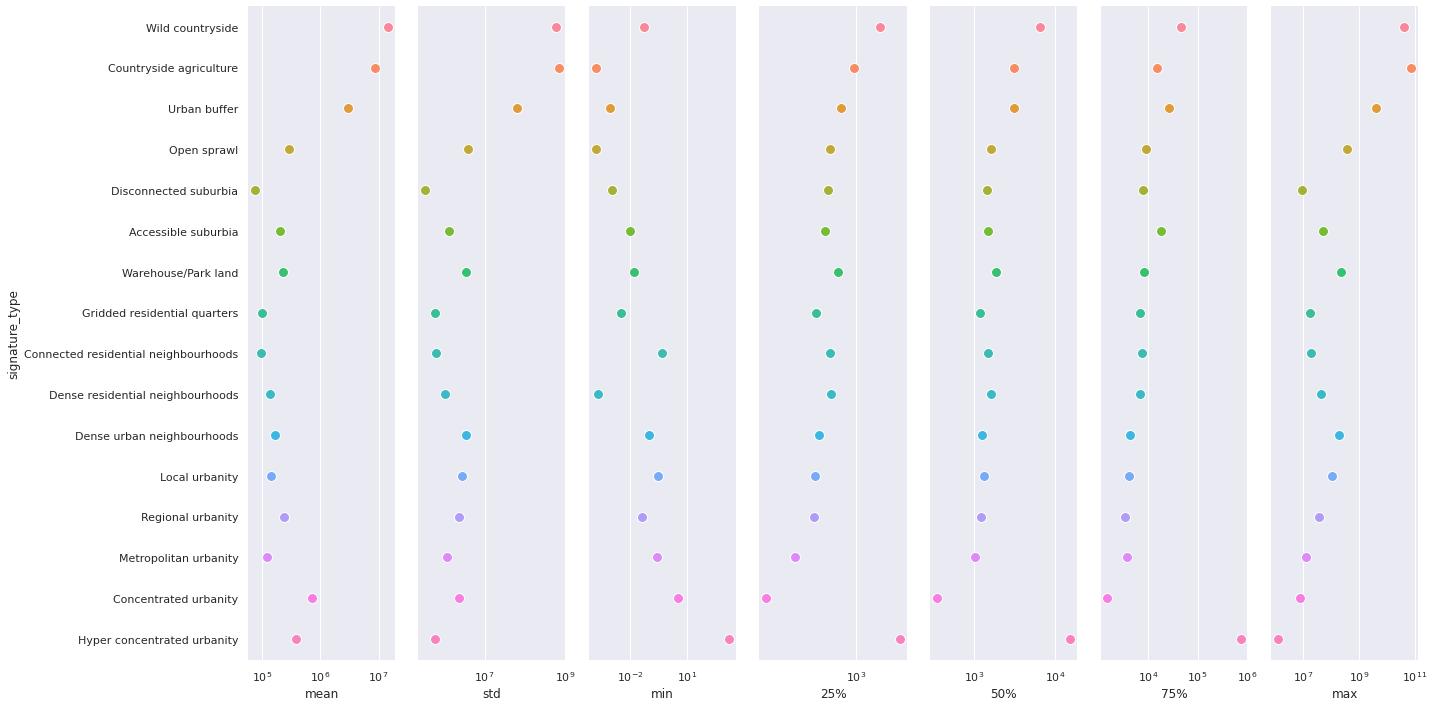

In [10]:
g = seaborn.PairGrid(grouped["area"].reset_index(),
                 x_vars=grouped["area"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
g.set(xscale='log')
seaborn.despine(left=True, bottom=True)

### Perimeter

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

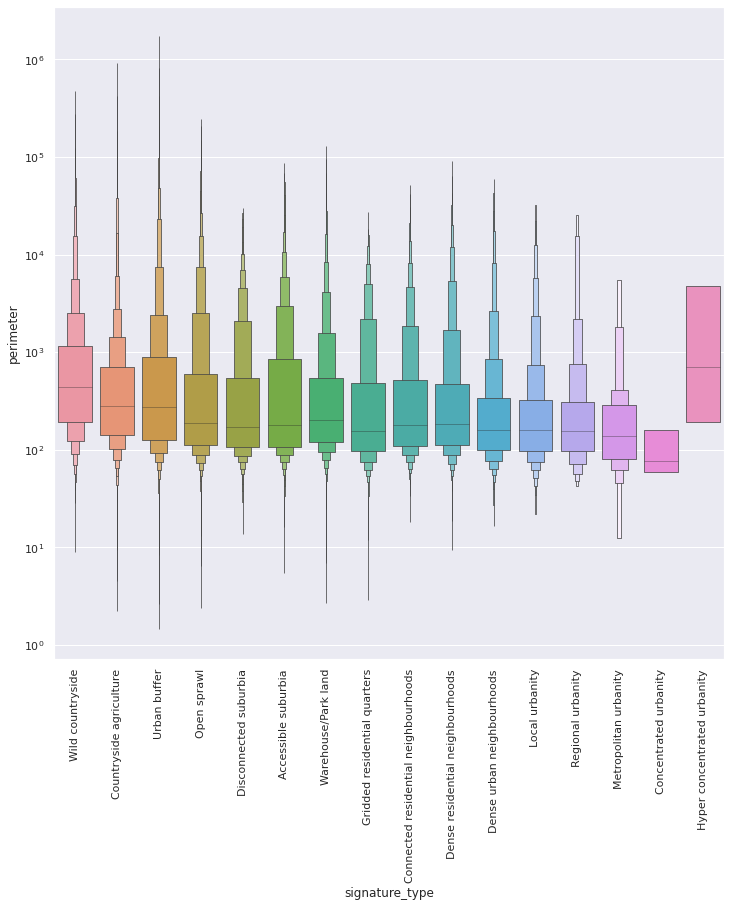

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='perimeter', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")
ax.legend_.remove()
plt.xticks(rotation=90)

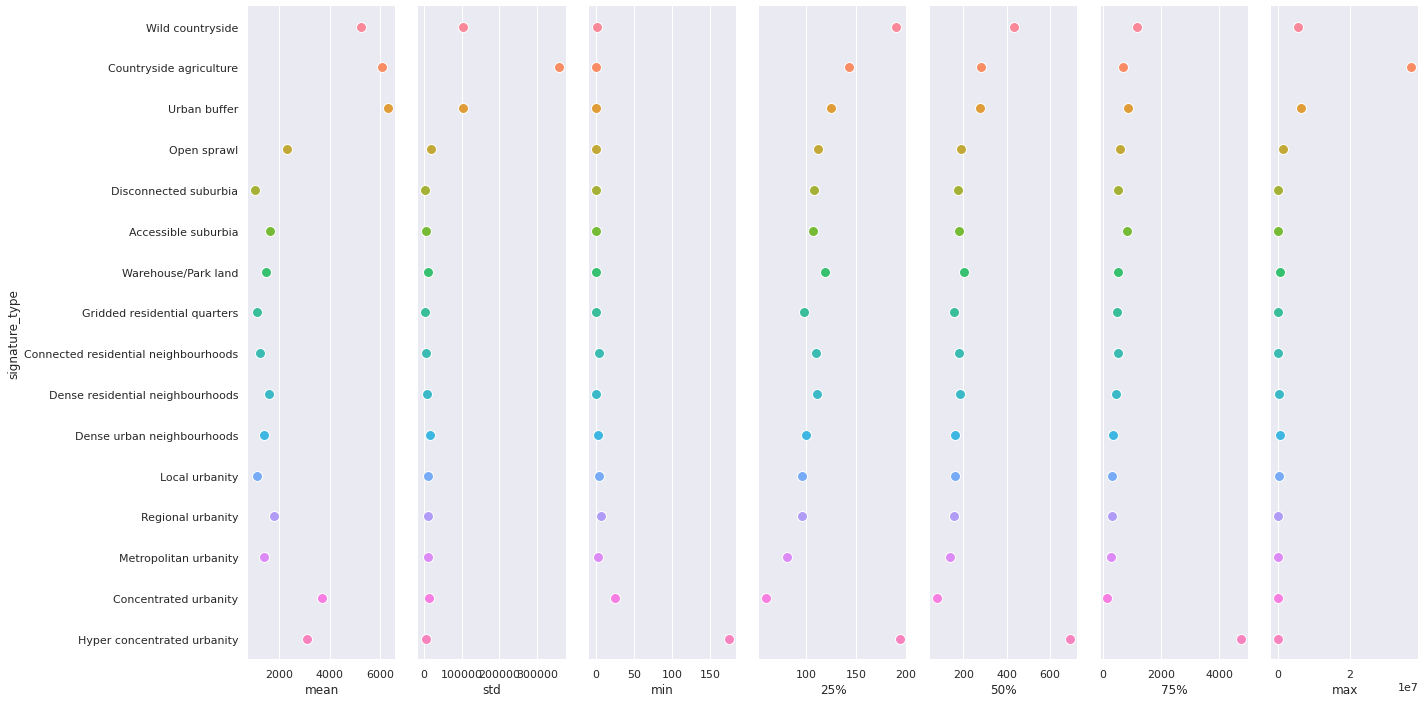

In [41]:
g = seaborn.PairGrid(grouped["perimeter"].reset_index(),
                 x_vars=grouped["perimeter"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

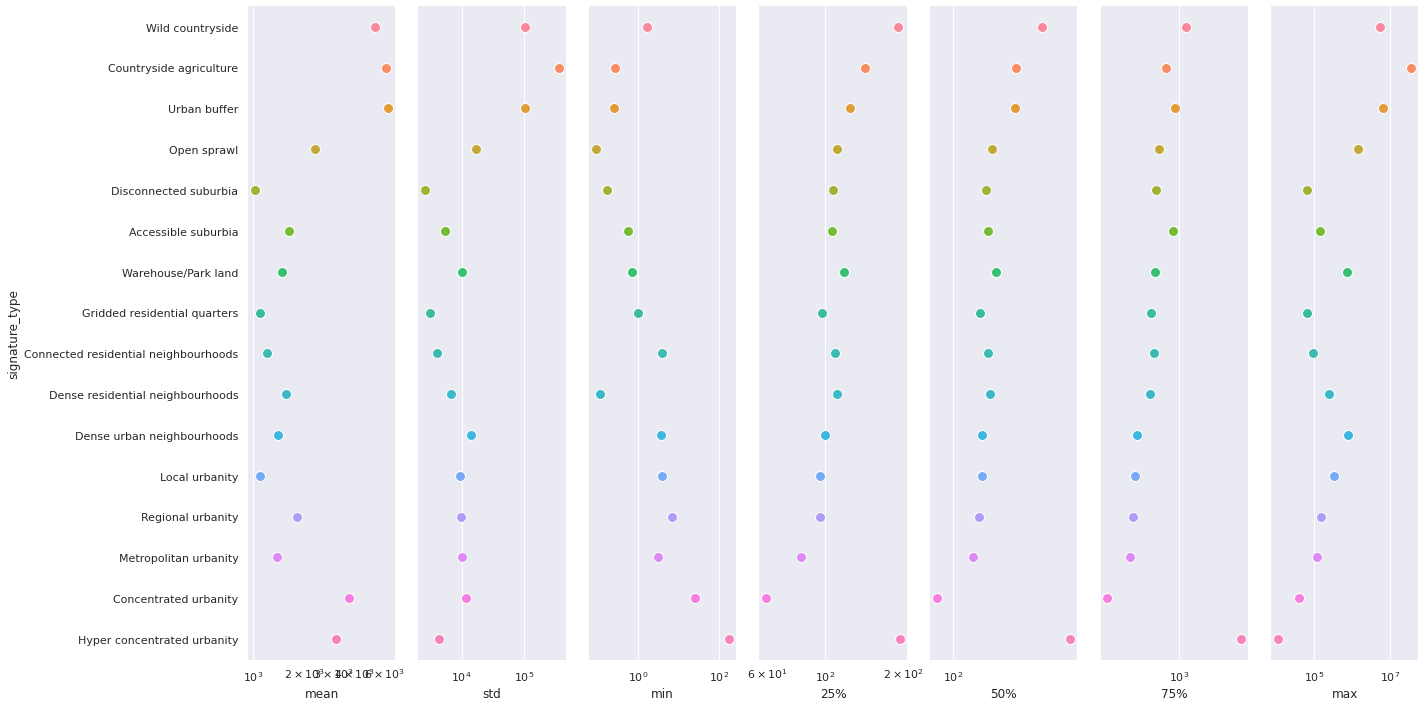

In [11]:
g = seaborn.PairGrid(grouped["perimeter"].reset_index(),
                 x_vars=grouped["perimeter"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
g.set(xscale='log')
seaborn.despine(left=True, bottom=True)

### ERI

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

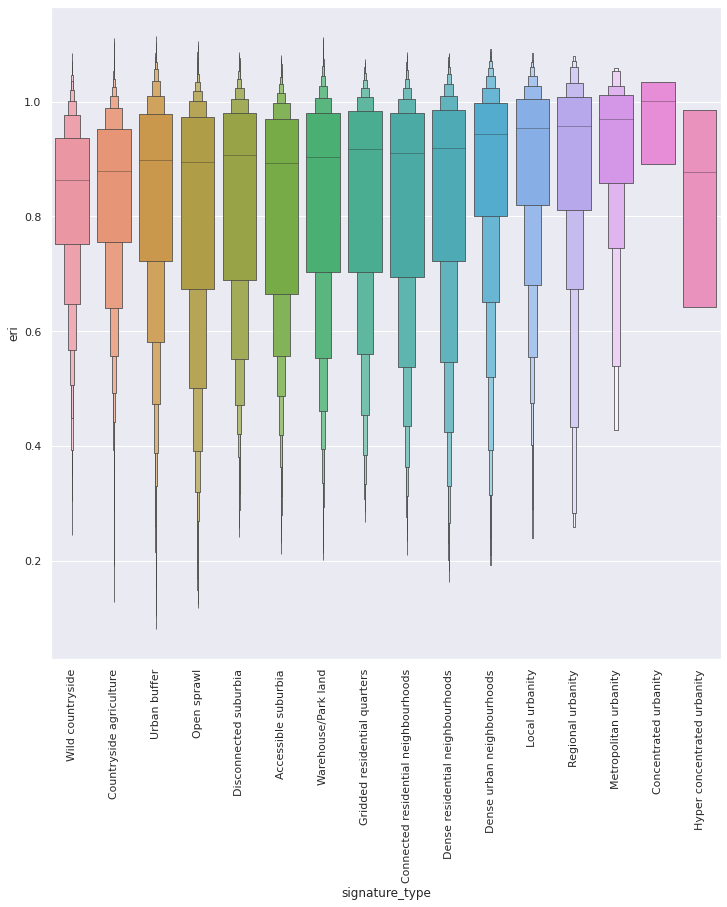

In [43]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='eri', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

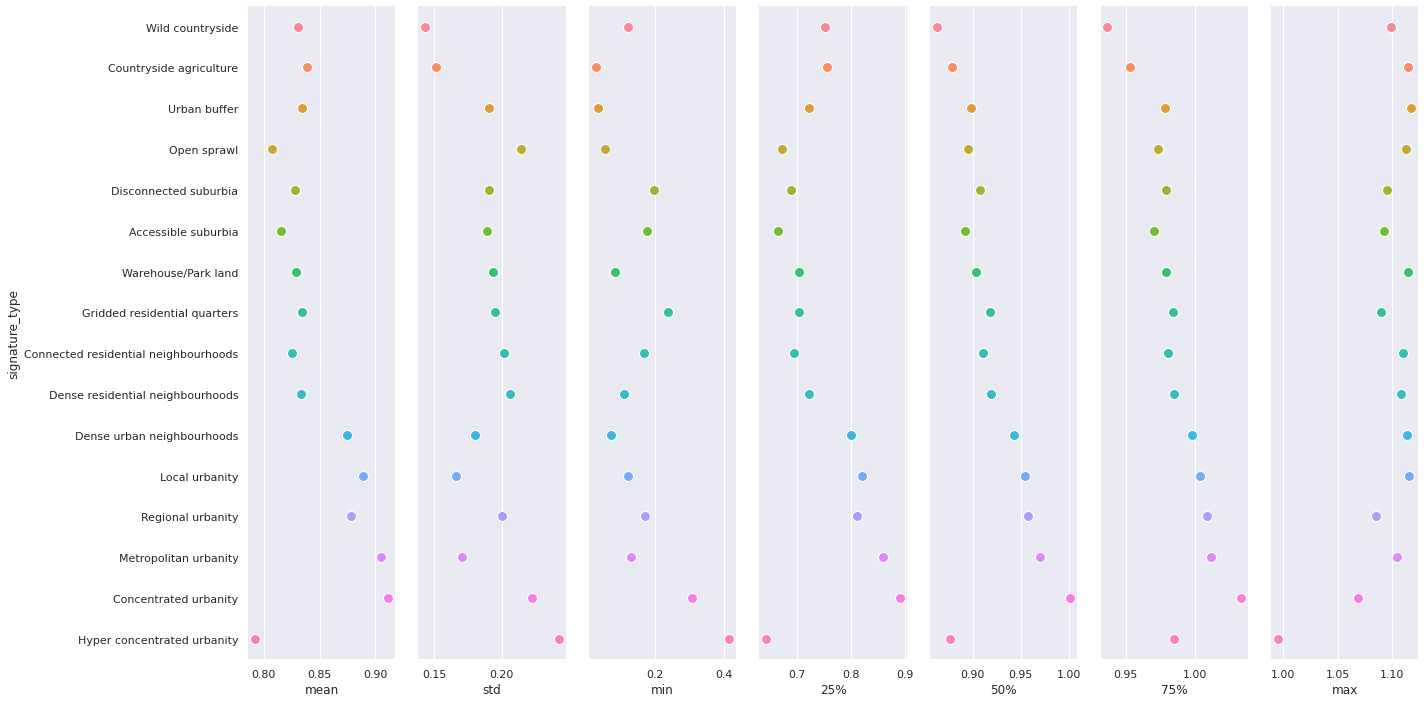

In [44]:
g = seaborn.PairGrid(grouped["eri"].reset_index(),
                 x_vars=grouped["eri"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Circlular compactness

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

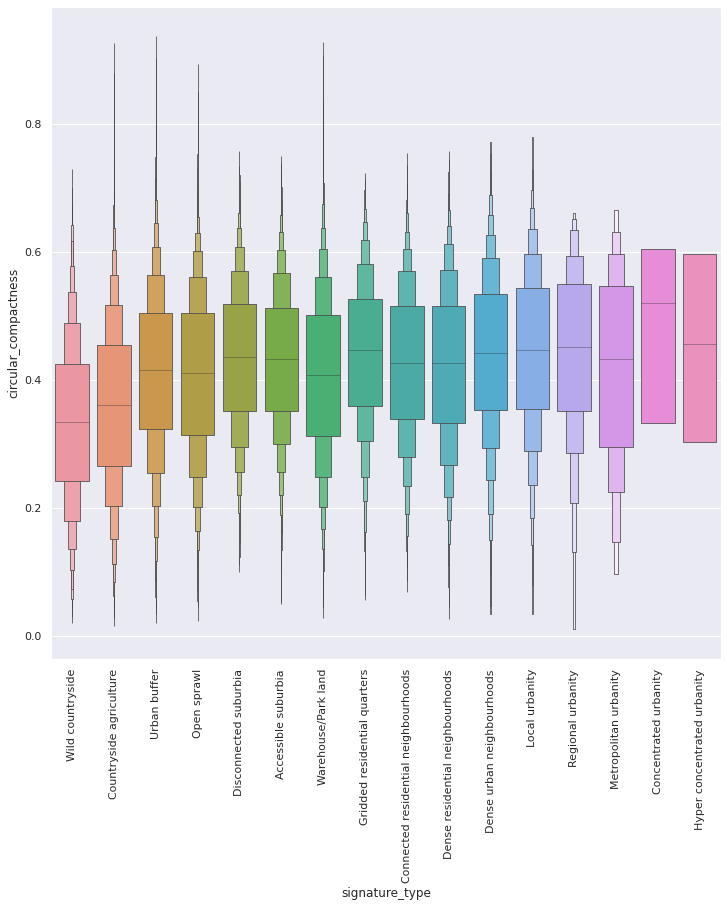

In [45]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='circular_compactness', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

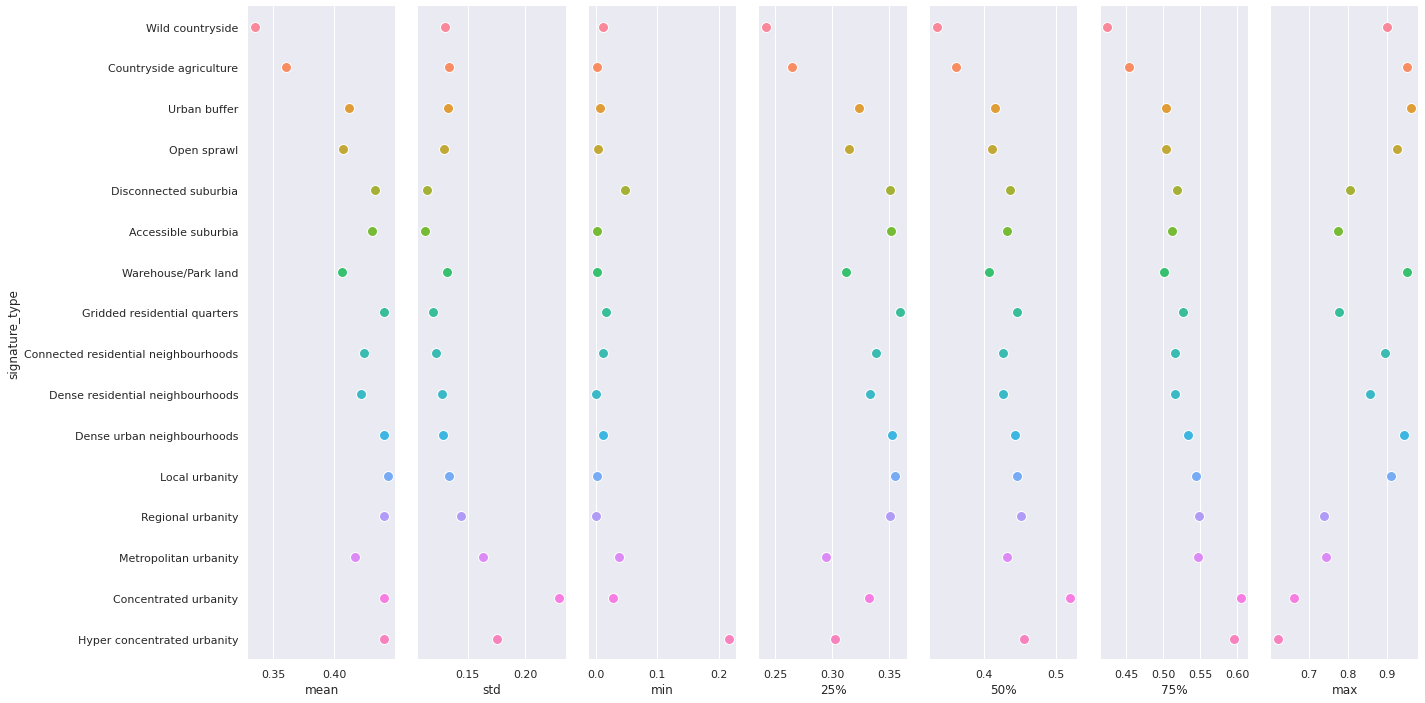

In [46]:
g = seaborn.PairGrid(grouped["circular_compactness"].reset_index(),
                 x_vars=grouped["circular_compactness"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Donut index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

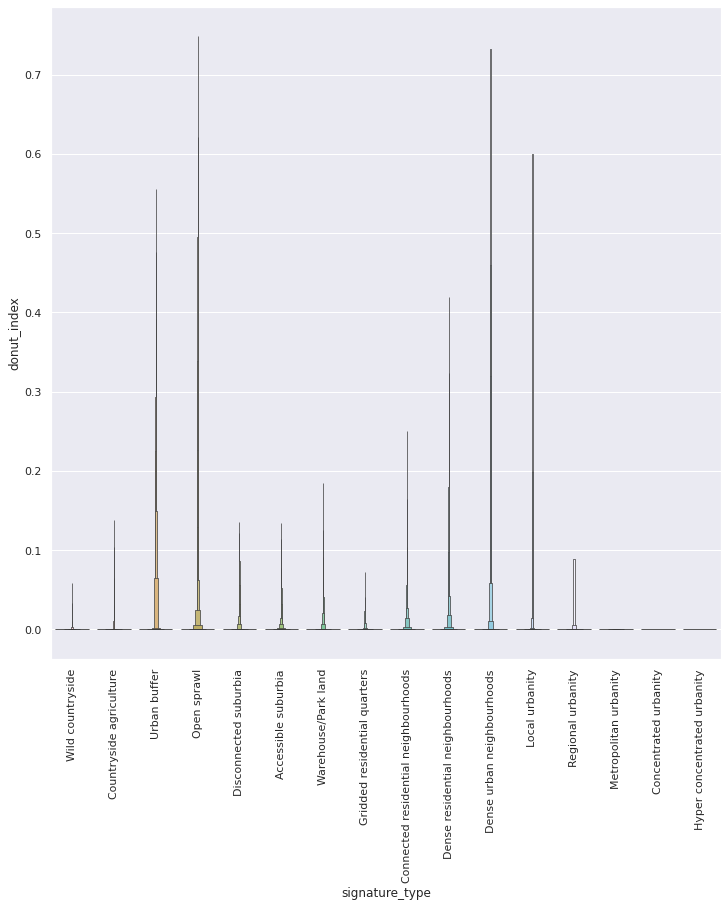

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='donut_index', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

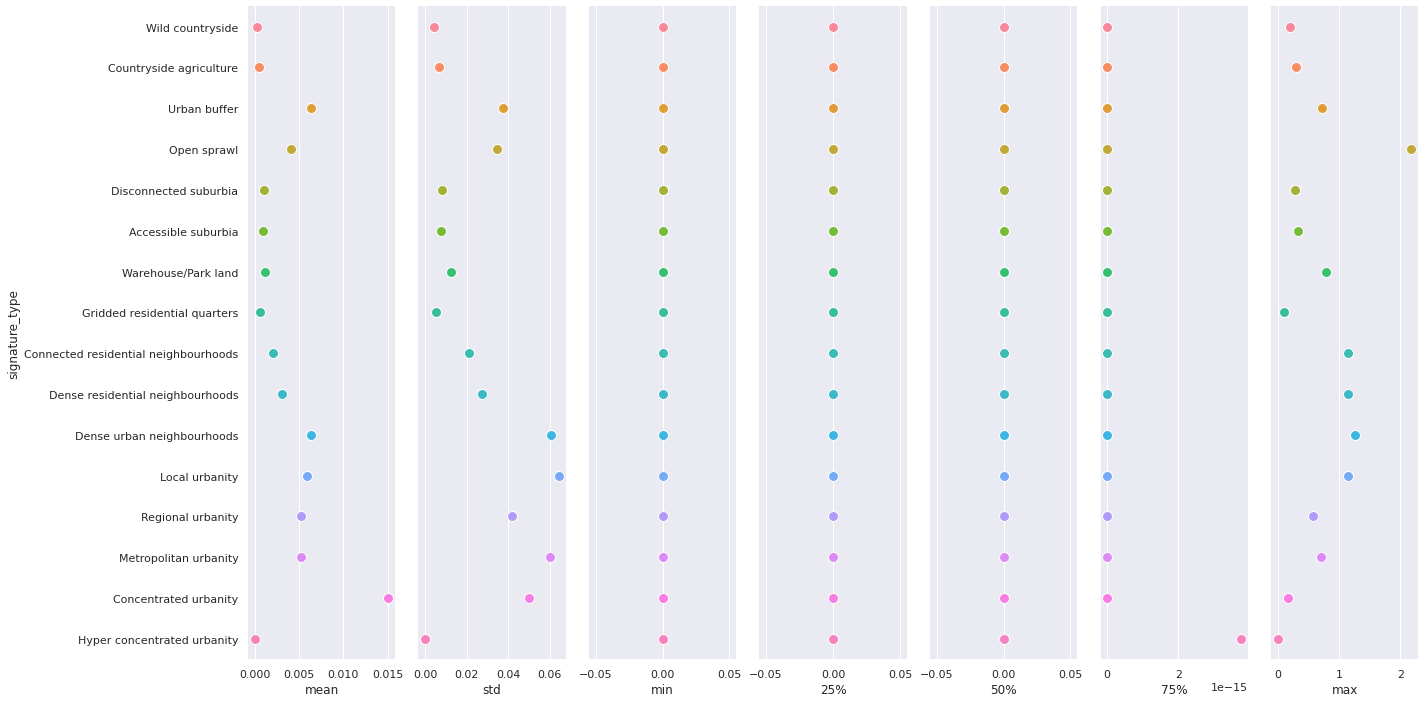

In [49]:
g = seaborn.PairGrid(grouped["donut_index"].reset_index(),
                 x_vars=grouped["donut_index"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Fractality

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

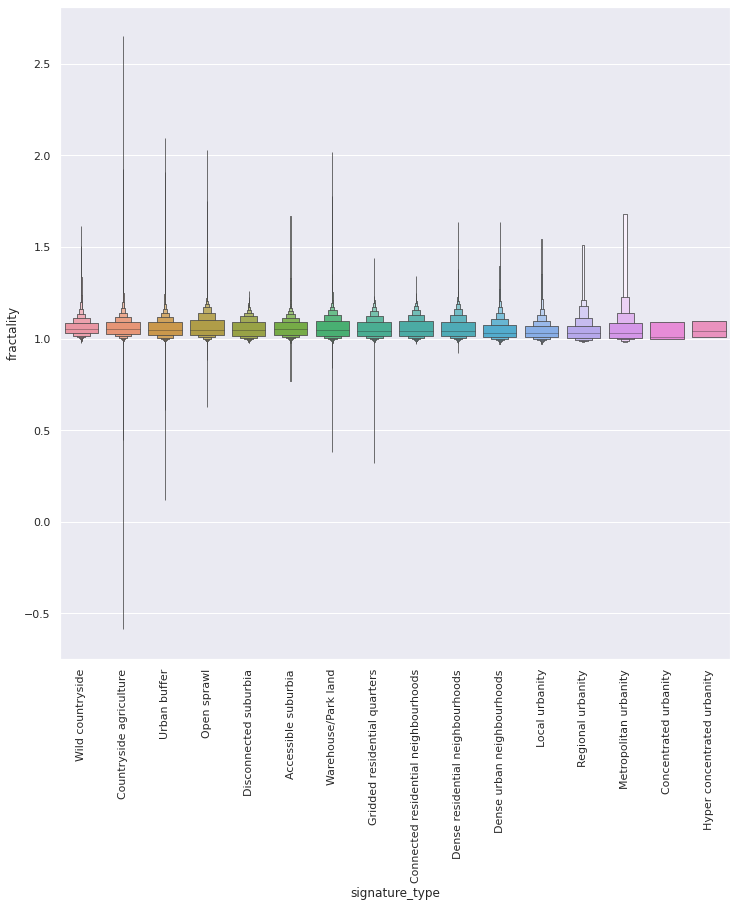

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='fractality', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

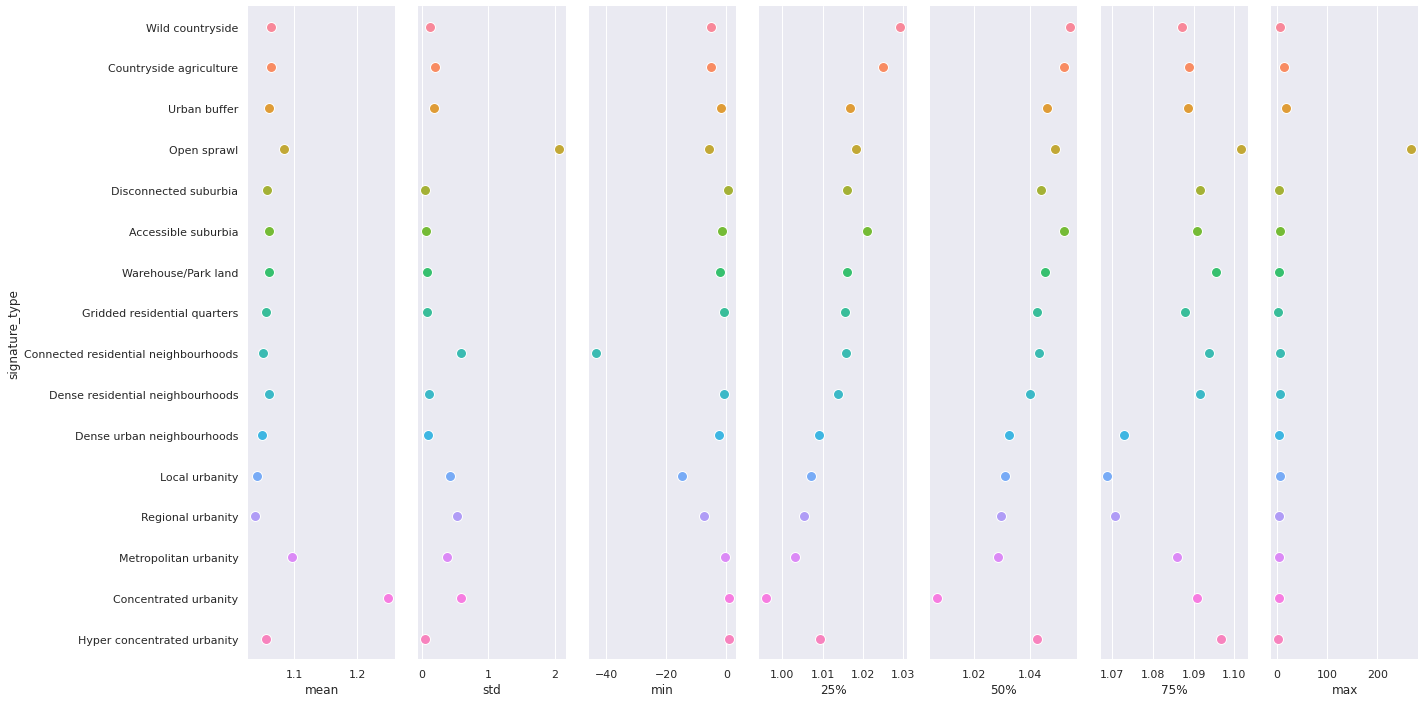

In [52]:
g = seaborn.PairGrid(grouped["fractality"].reset_index(),
                 x_vars=grouped["fractality"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Convexity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

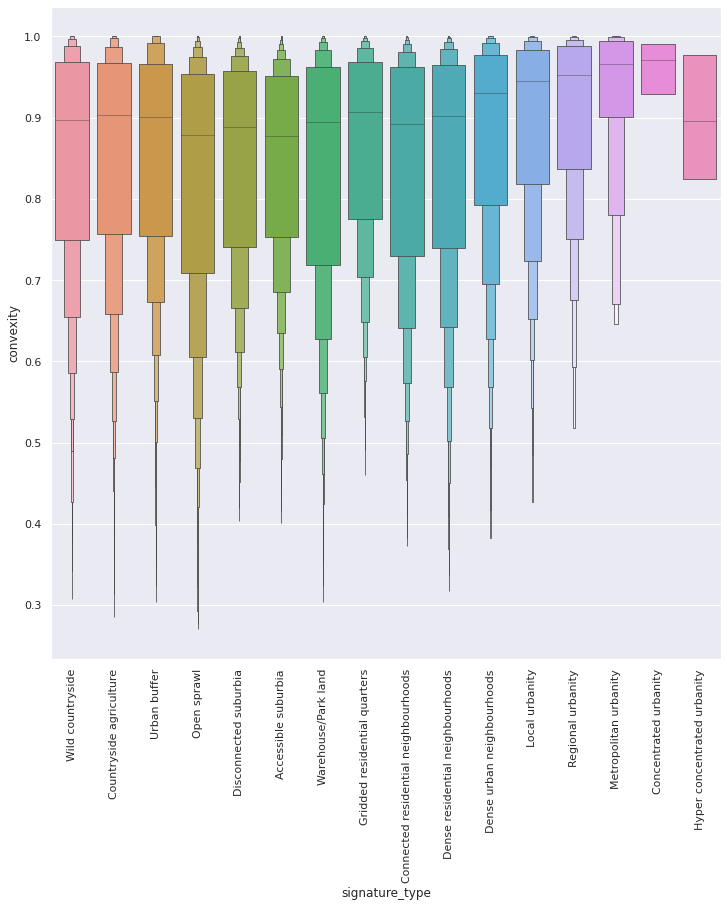

In [53]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='convexity', hue='signature_type', dodge=False, data=signatures, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

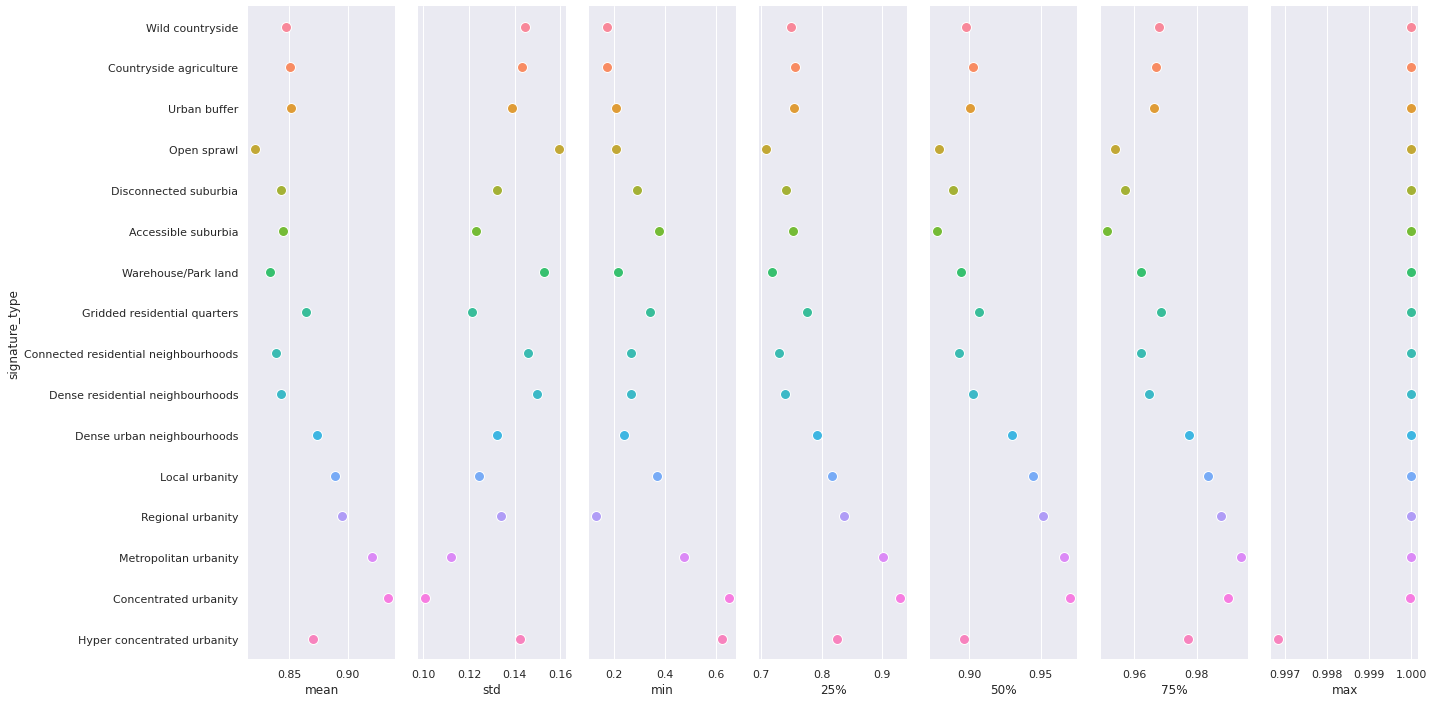

In [54]:
g = seaborn.PairGrid(grouped["convexity"].reset_index(),
                 x_vars=grouped["convexity"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

## Using only 50% largest signatures per each type

The rationale is that it eliminates the "noise".

In [12]:
mask = pandas.Series(numpy.zeros(len(signatures), dtype=bool), index=signatures.index)

for cl in signatures.signature_type.unique():
    sub = signatures[signatures.signature_type == cl]
    mean = sub.area.mean()
    above = sub.area > mean
    mask[above[above].index] = True

In [13]:
mask.sum()

6915

In [14]:
significant = signatures[mask]

In [15]:
significant_grouped = significant.groupby("signature_type").describe()

### Area

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

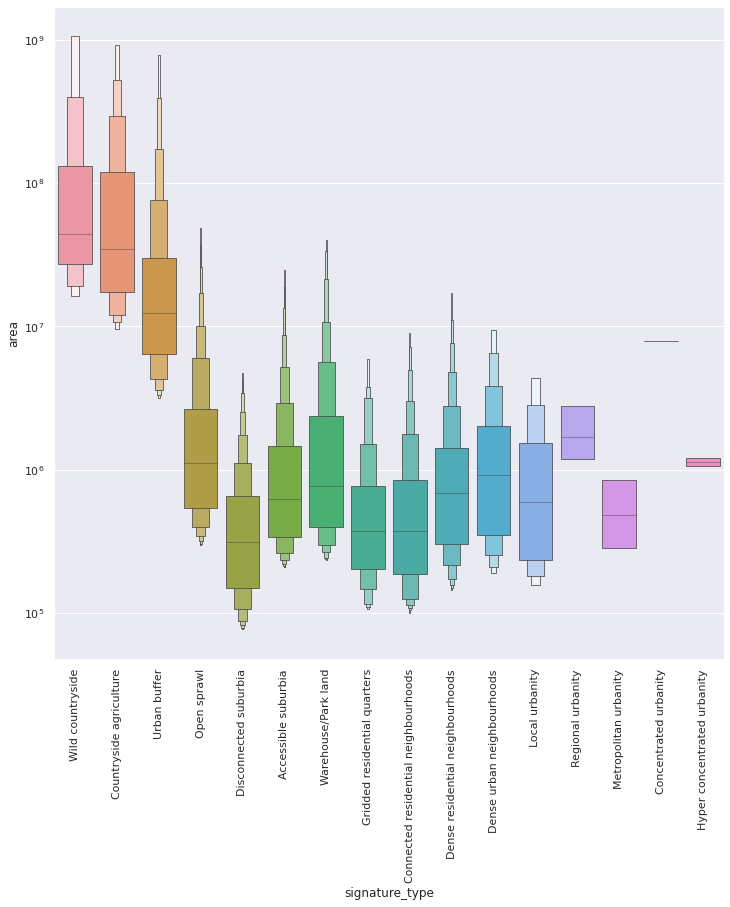

In [59]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='area', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")
ax.legend_.remove()
plt.xticks(rotation=90)

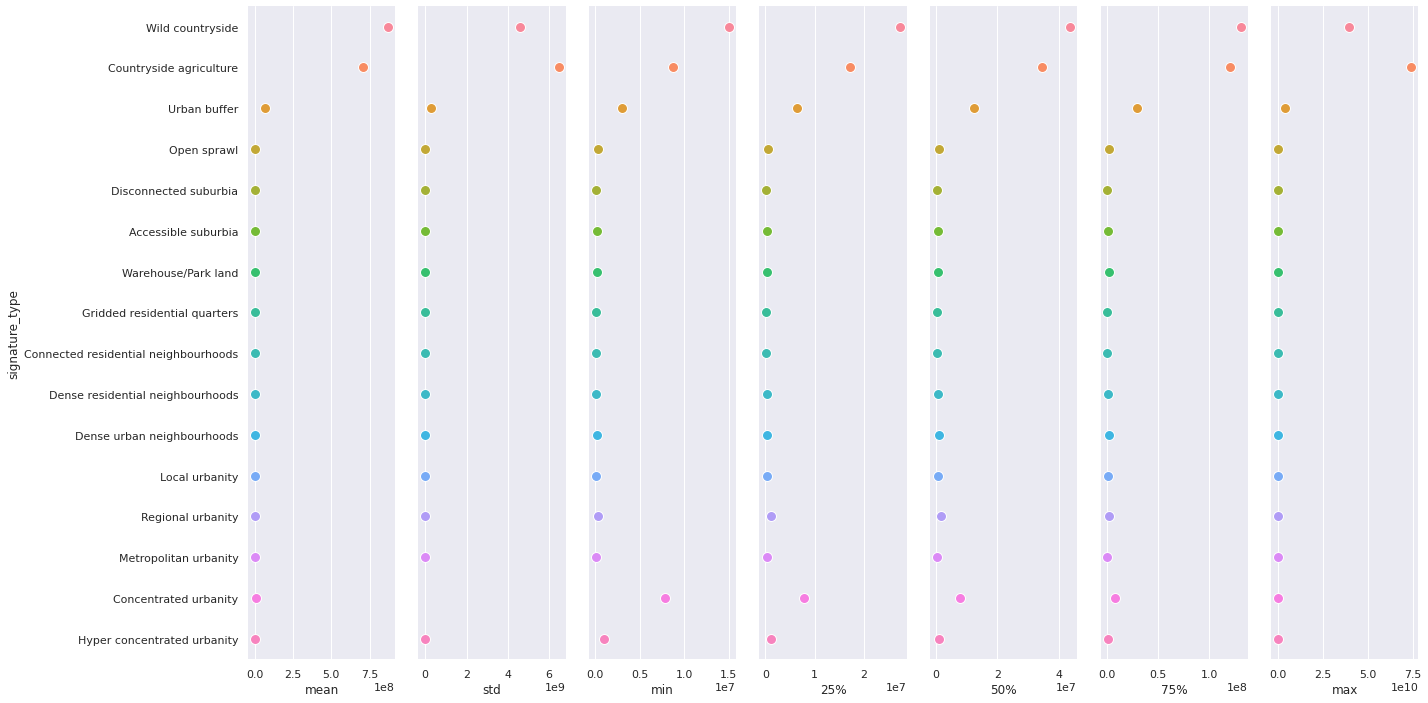

In [60]:
g = seaborn.PairGrid(significant_grouped["area"].reset_index(),
                 x_vars=significant_grouped["area"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

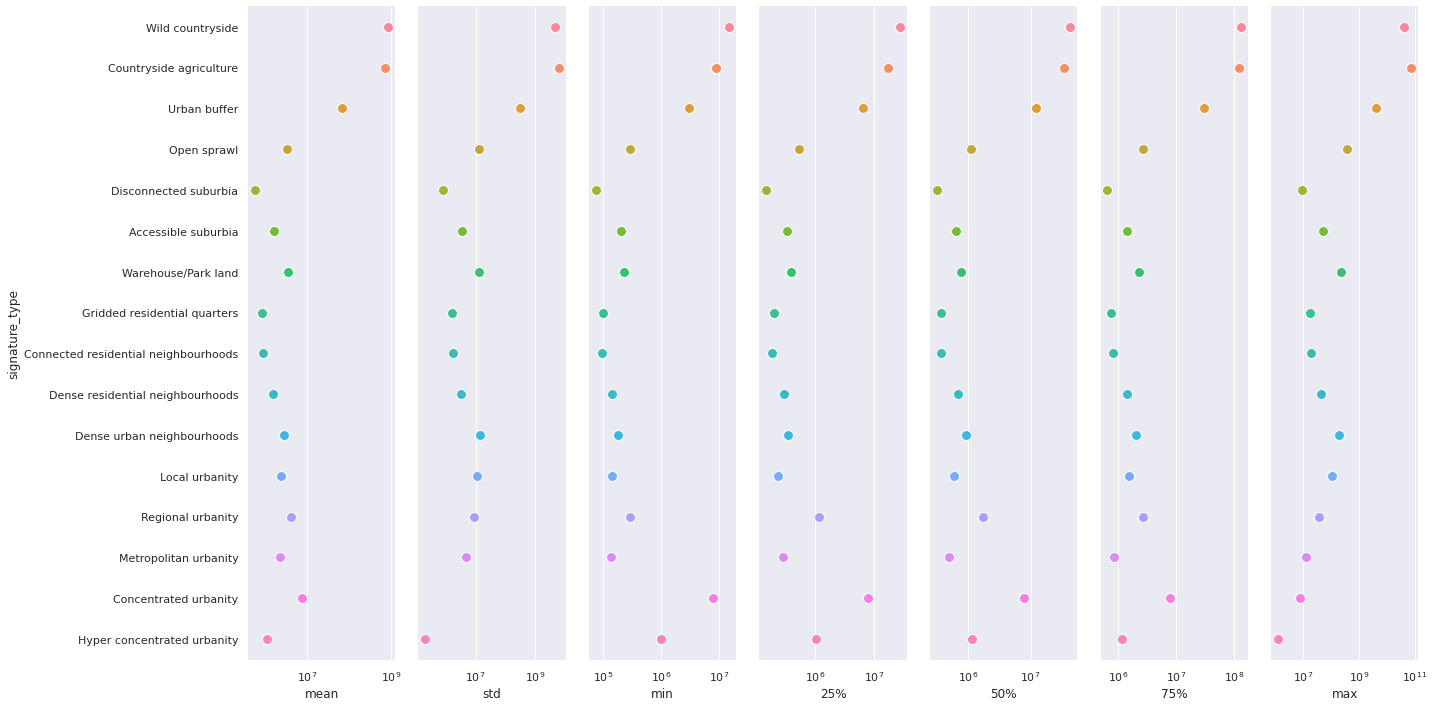

In [16]:
g = seaborn.PairGrid(significant_grouped["area"].reset_index(),
                 x_vars=significant_grouped["area"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
g.set(xscale='log')
seaborn.despine(left=True, bottom=True)

### Perimeter

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

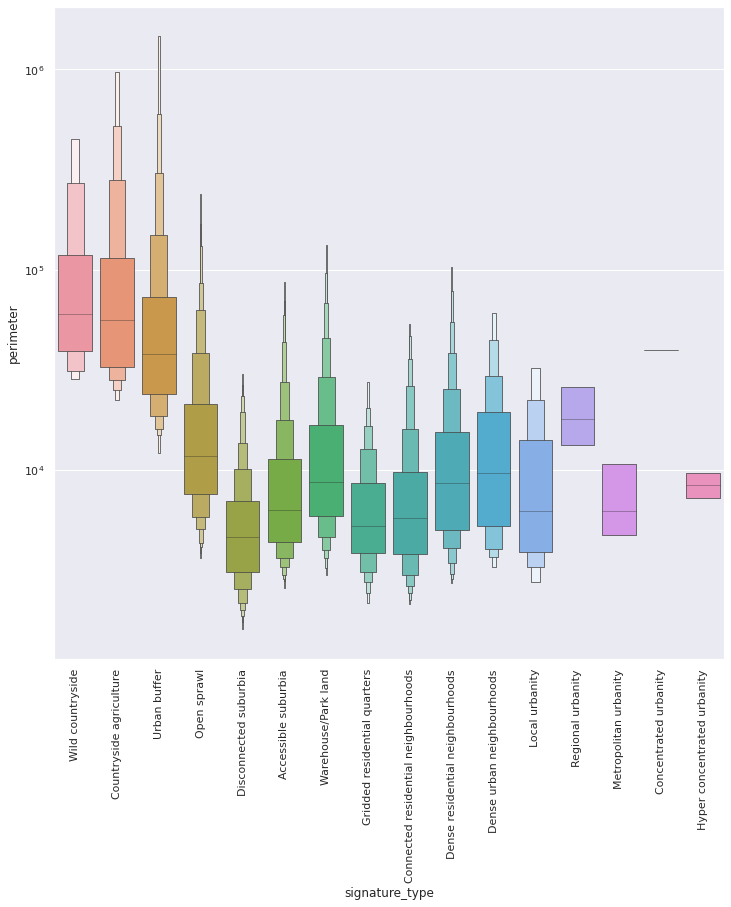

In [61]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='perimeter', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.set_yscale("log")
ax.legend_.remove()
plt.xticks(rotation=90)

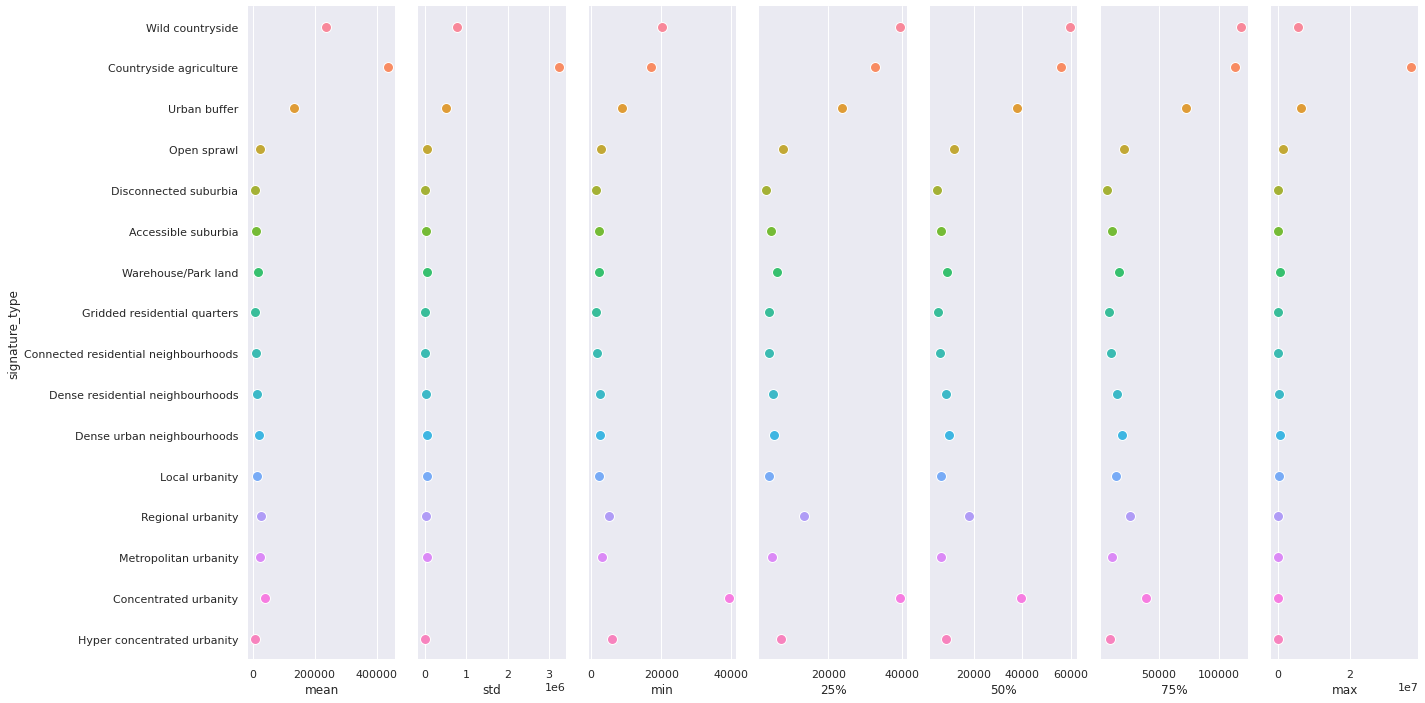

In [62]:
g = seaborn.PairGrid(significant_grouped["perimeter"].reset_index(),
                 x_vars=significant_grouped["perimeter"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

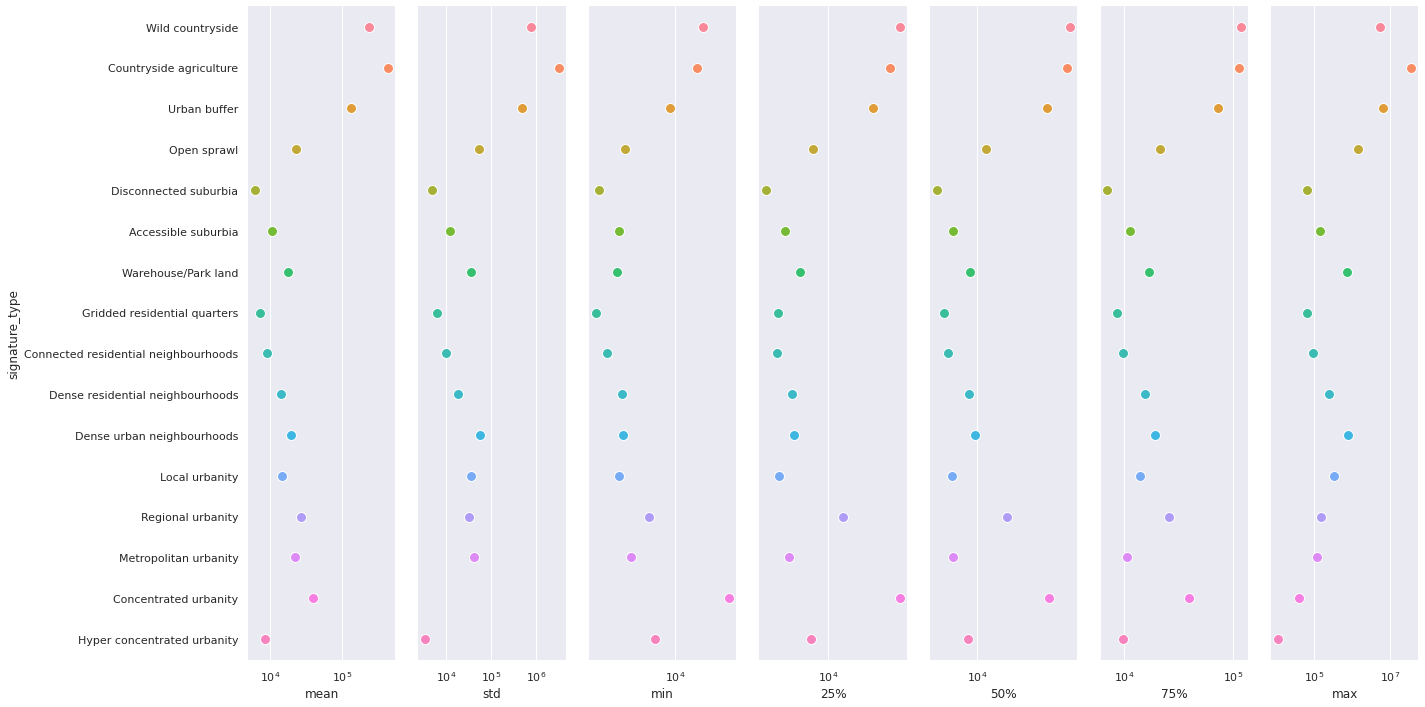

In [17]:
g = seaborn.PairGrid(significant_grouped["perimeter"].reset_index(),
                 x_vars=significant_grouped["perimeter"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
g.set(xscale='log')
seaborn.despine(left=True, bottom=True)

### ERI

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

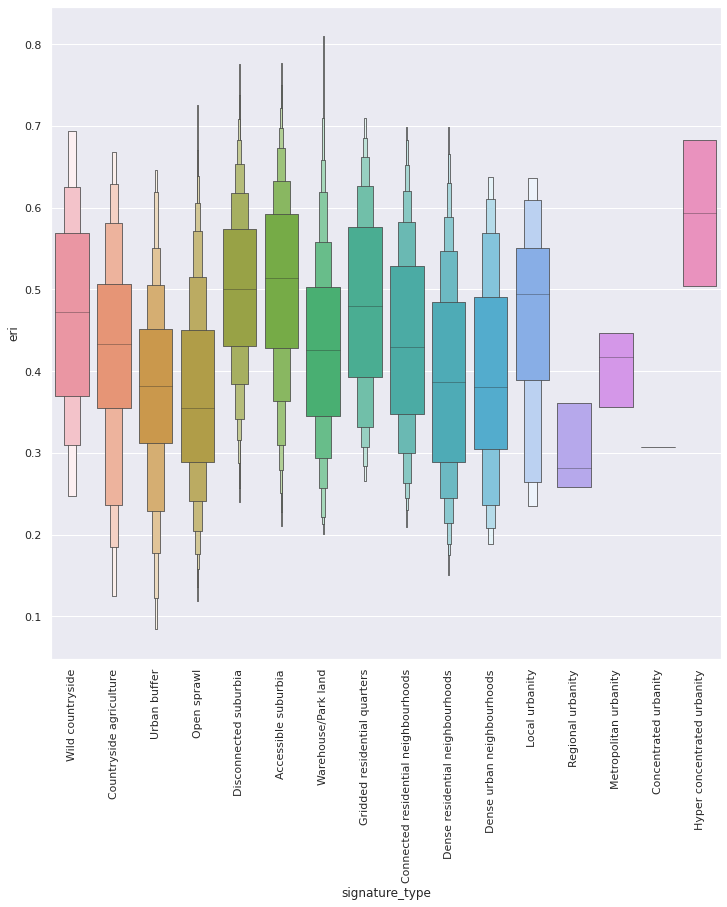

In [63]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='eri', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

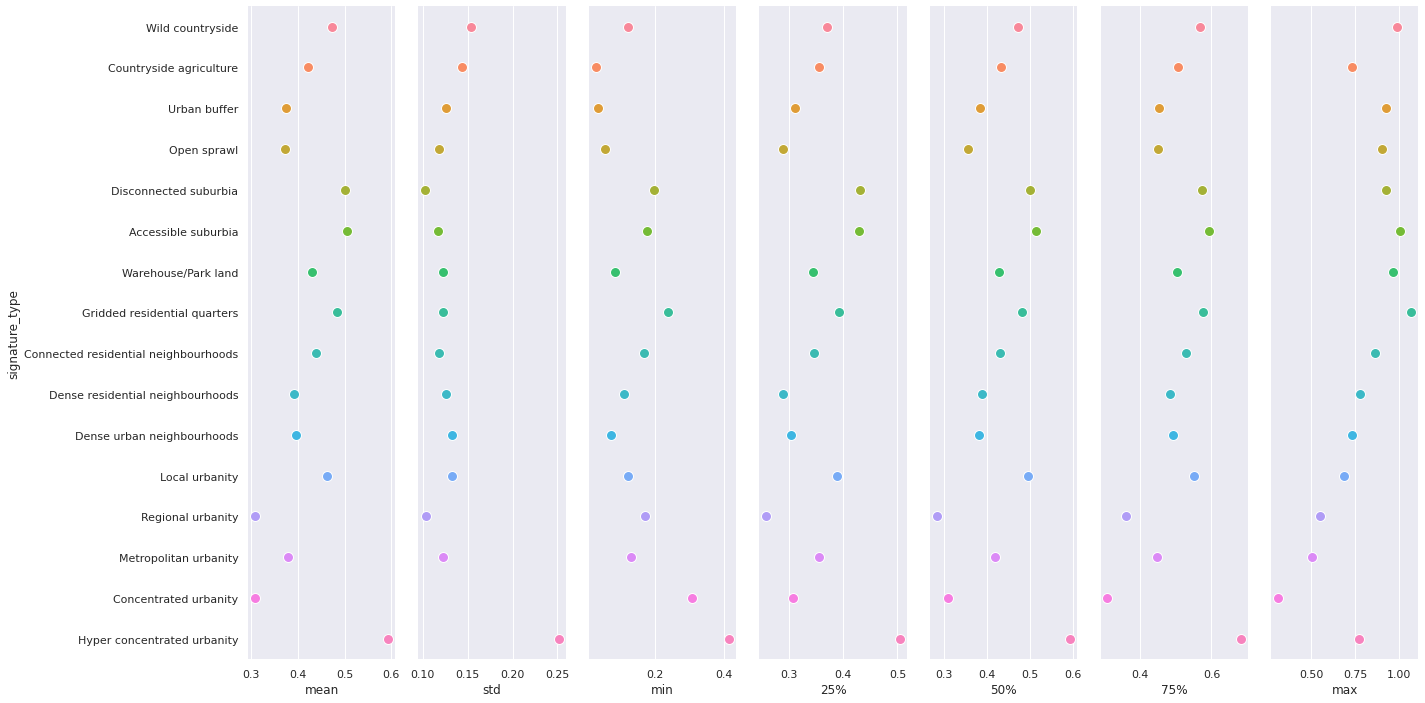

In [64]:
g = seaborn.PairGrid(significant_grouped["eri"].reset_index(),
                 x_vars=significant_grouped["eri"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Circlular compactness

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

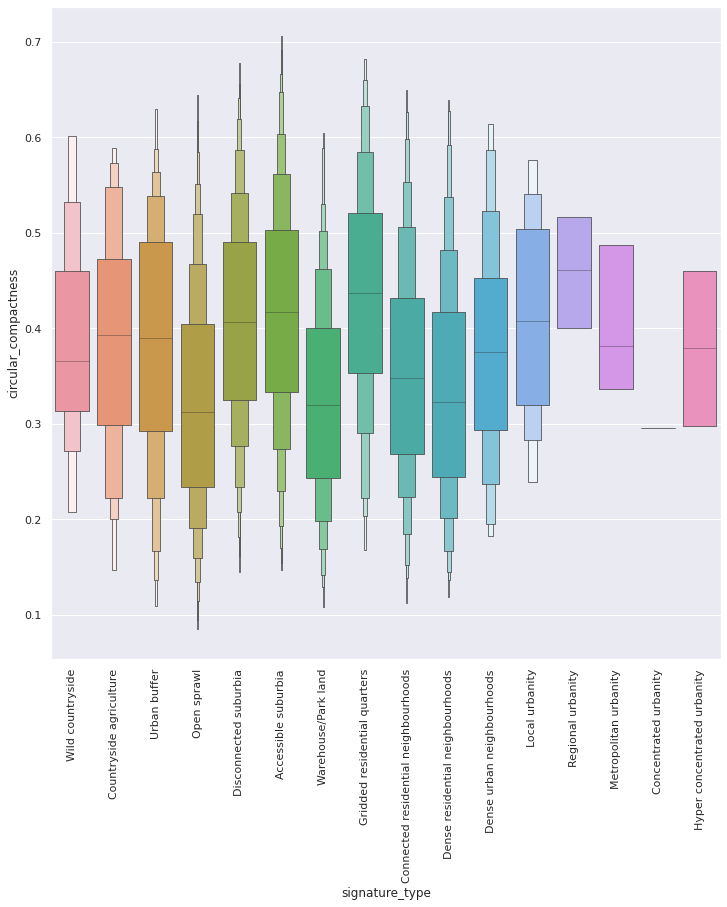

In [65]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='circular_compactness', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

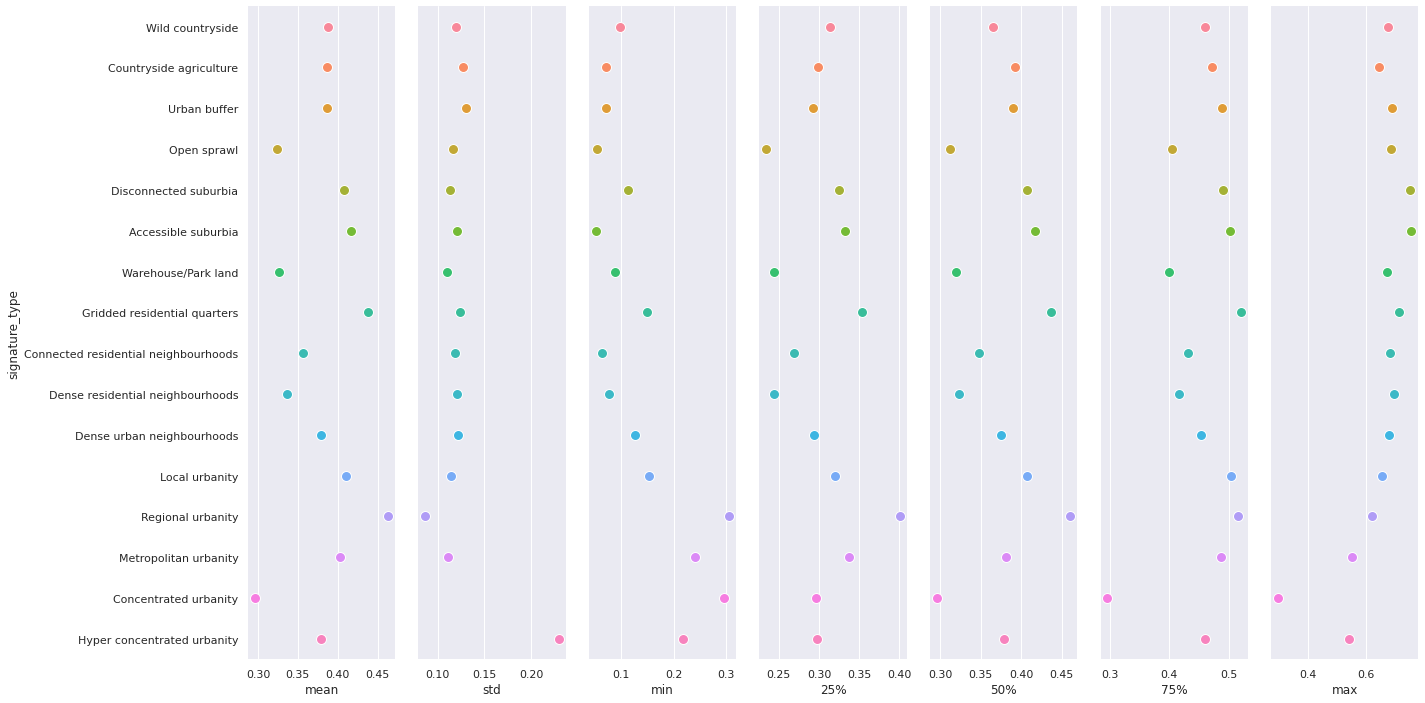

In [66]:
g = seaborn.PairGrid(significant_grouped["circular_compactness"].reset_index(),
                 x_vars=significant_grouped["circular_compactness"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Donut index

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

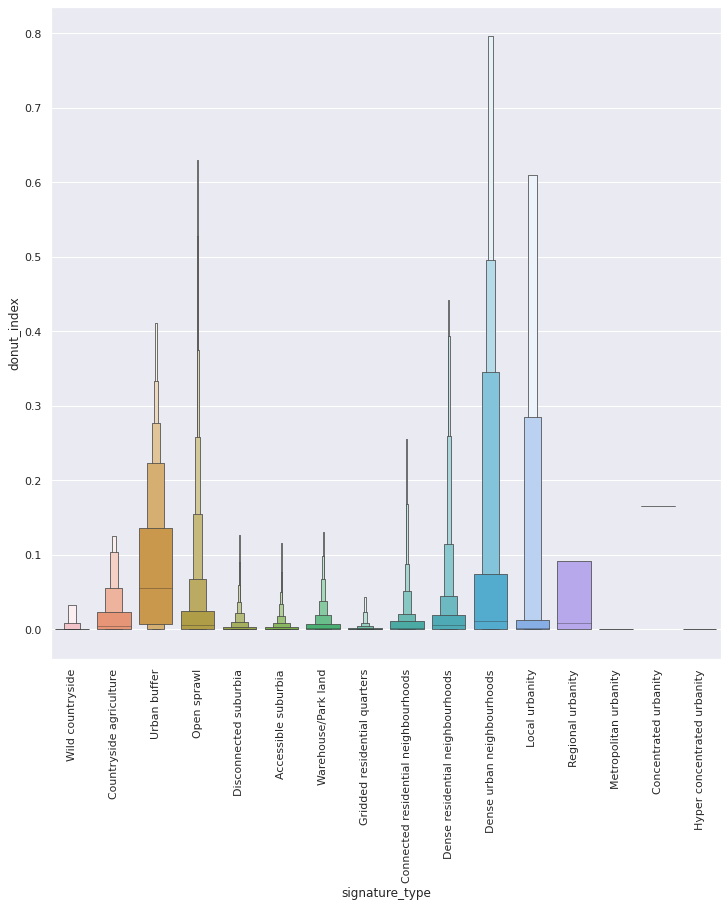

In [67]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='donut_index', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

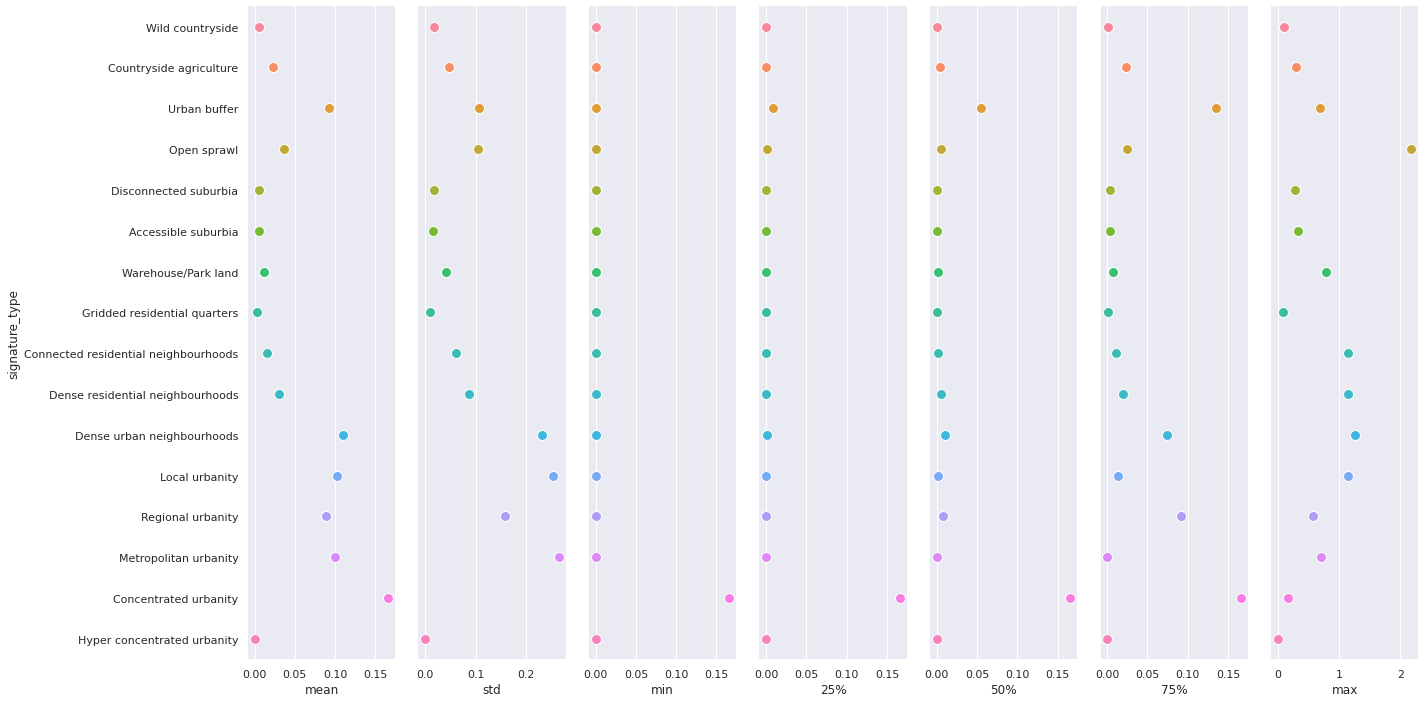

In [68]:
g = seaborn.PairGrid(significant_grouped["donut_index"].reset_index(),
                 x_vars=significant_grouped["donut_index"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Fractality

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

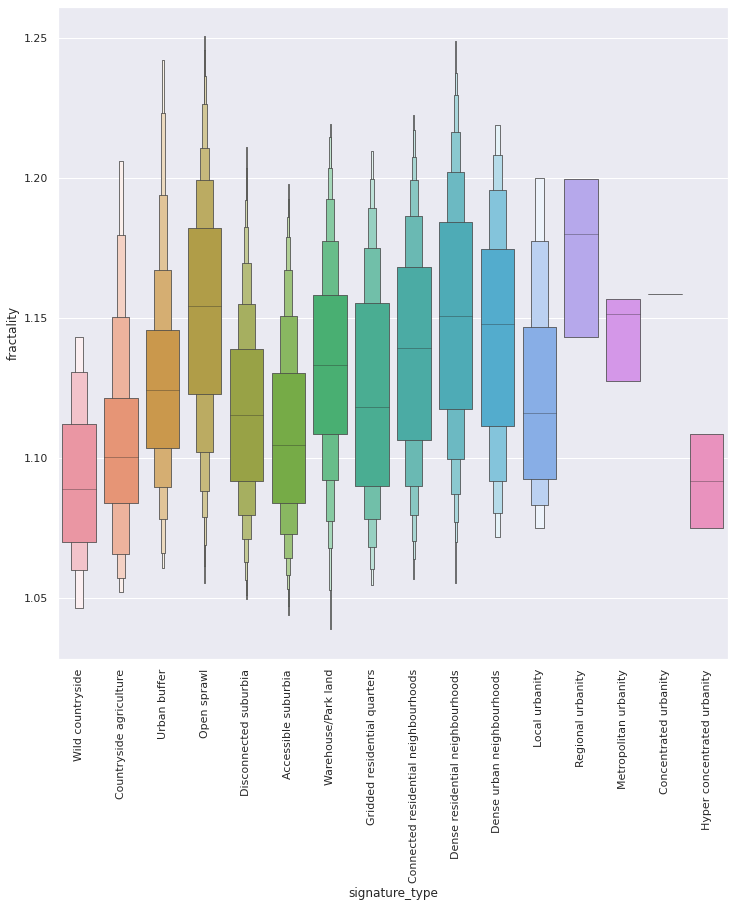

In [69]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='fractality', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

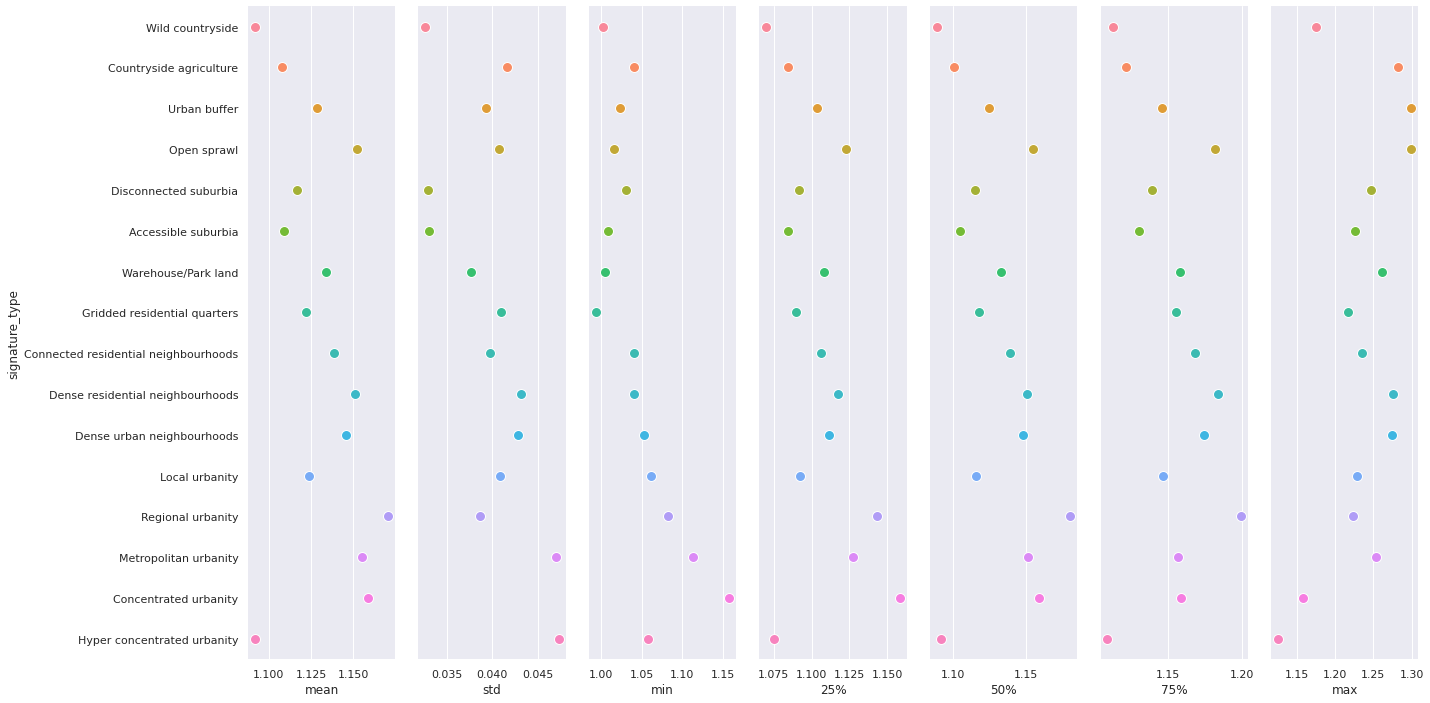

In [70]:
g = seaborn.PairGrid(significant_grouped["fractality"].reset_index(),
                 x_vars=significant_grouped["fractality"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

### Convexity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Wild countryside'),
  Text(1, 0, 'Countryside agriculture'),
  Text(2, 0, 'Urban buffer'),
  Text(3, 0, 'Open sprawl'),
  Text(4, 0, 'Disconnected suburbia'),
  Text(5, 0, 'Accessible suburbia'),
  Text(6, 0, 'Warehouse/Park land'),
  Text(7, 0, 'Gridded residential quarters'),
  Text(8, 0, 'Connected residential neighbourhoods'),
  Text(9, 0, 'Dense residential neighbourhoods'),
  Text(10, 0, 'Dense urban neighbourhoods'),
  Text(11, 0, 'Local urbanity'),
  Text(12, 0, 'Regional urbanity'),
  Text(13, 0, 'Metropolitan urbanity'),
  Text(14, 0, 'Concentrated urbanity'),
  Text(15, 0, 'Hyper concentrated urbanity')])

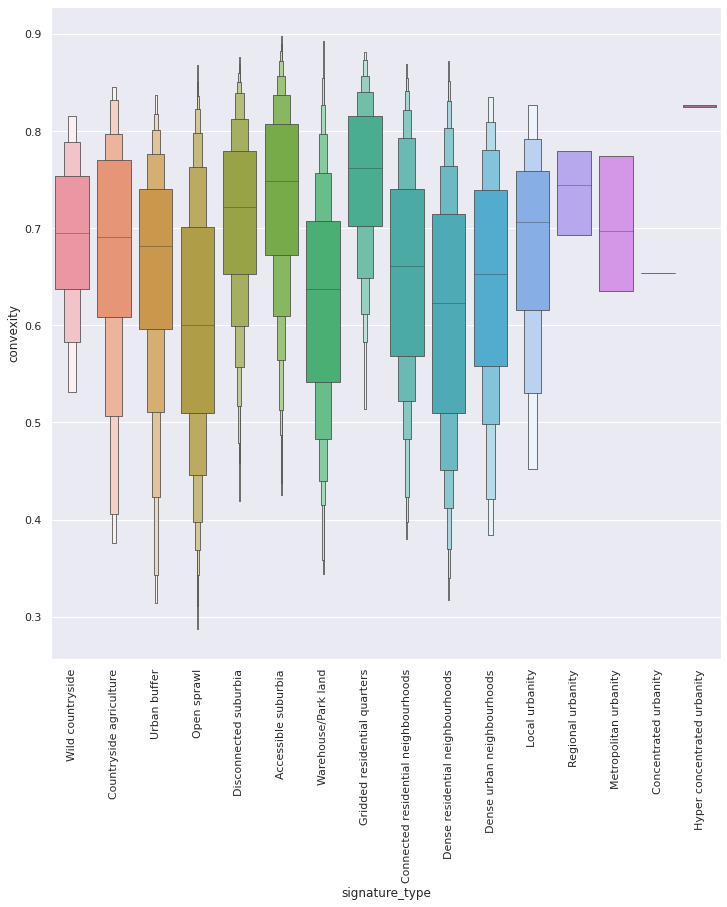

In [71]:
fig, ax = plt.subplots(figsize=(12, 12))
seaborn.boxenplot(x="signature_type", y='convexity', hue='signature_type', dodge=False, data=significant, ax=ax, showfliers=False, linewidth=.75)
ax.legend_.remove()
plt.xticks(rotation=90)

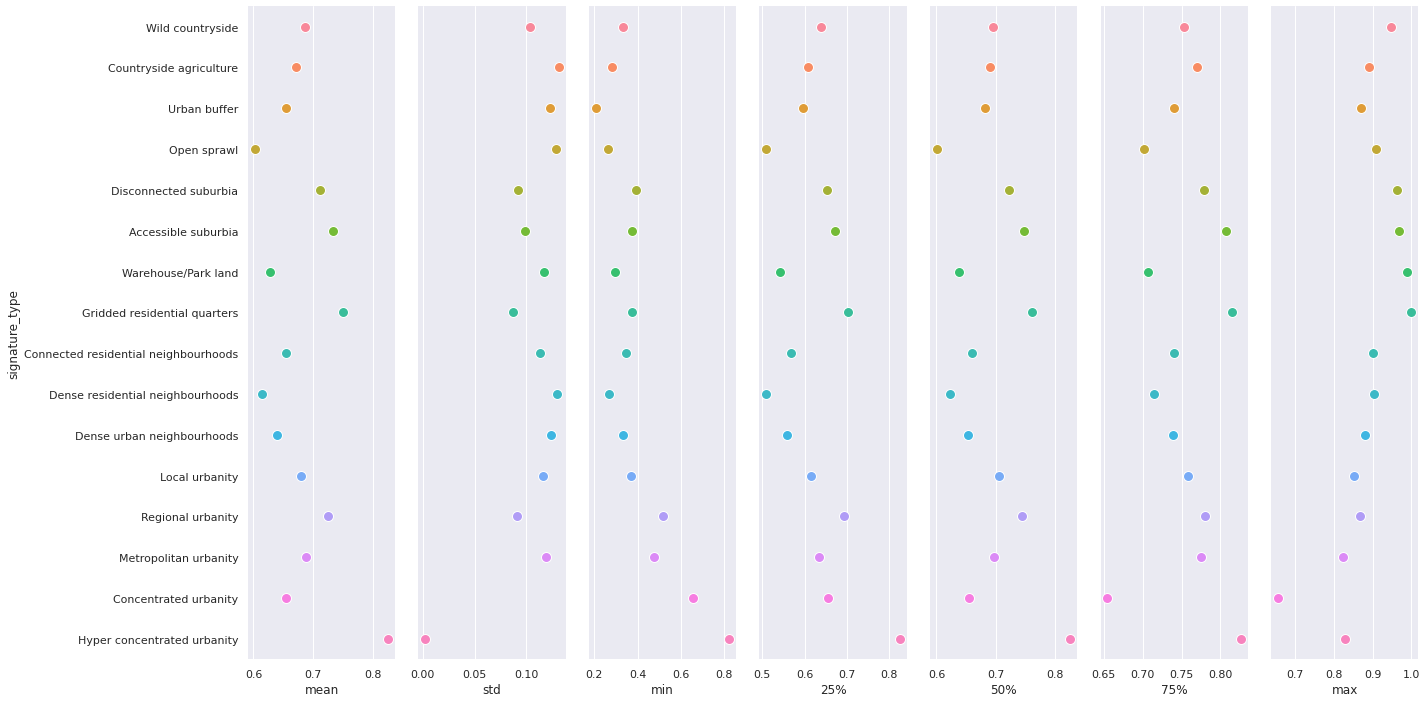

In [72]:
g = seaborn.PairGrid(significant_grouped["convexity"].reset_index(),
                 x_vars=significant_grouped["convexity"].columns[1:], y_vars=["signature_type"],
                 height=10, aspect=.25)
g.map(seaborn.stripplot, size=10, orient="h", jitter=False,
      linewidth=1, edgecolor="w")
seaborn.despine(left=True, bottom=True)

## Notes

### Area

*Wild countryside*, *Countryside agriculture* and *Urban buffer* much larger than the rest. The difference between more urban signatures is small, with an exception of *Warehouse/Park land* that tends to be a bit larger and *Disconnected suburbia* that tends to be smaller.

### Perimeter

Very similar as area, we could almost say the same.

### Equivalent rectangular index

*(higher the value is, less complex the shape is)*

There's an intereseting tendency shown - more urban signatures tend to be less complex in shape than rural ones and there is almost a gradient of increasing complexity as we lose urbanity. In other words, more urban singatures have much simpler shapes.

However, this clear tendency is lost when we take into account only 50% largest polygons.

### Circular compactness

*(higher value means more compact, circle-like shape)*

Nothing super interesting comes up. Countryside tends to have less compact shapes but the rest doesn't tell much.

### Donut index

*(higher values means more holes)*

This is interesting. We have two groups of signatures showing donut-like tendency. 

- Countryside right next to the city - *urban buffer* and *open sprawl* have a tendency to encircle more urban development
- Dense central areas - *dense urban neighbourhoods* and the *urbanity* singatures tend to form concentric rings, therefore having a donut shape.

### Fractality

*(higher means more fractal-like)*

There is some variation, especially looking only at top 50% but I am not sure if there is any specific tendency apart from a relative randomness.

### Convexity

*(1 means convex, 0 complex)*

Again, not sure if it shows anything meaningful.